<font size=5  color=#003366> **[LGBIO2020] - Bioinstrumentation <br><br> 
Practical session 02 - FFT and Wavelets ** </font> <br><br><br>

<font size=5  color=#003366>
Prof. M. Verleysen<br>
Prof. A. Moureaux<br>

<br><br>
Anne-Sophie Collin (anne-sophie.collin@uclouvain.be)<br> 
<div style="text-align: right"> 2021-2022 </div>
<br><br>
</font>

<font size=5 color=#009999> <b>1. Context </b> </font> <br> <br>

One of the main concerns when recording with biological signals is assuring that we record clean data with a high signal to noise ratio. The recorded signal is usually of low amplitude and it is easily contaminated with noise, known as "artifacts", which need to be filtered from the processes to keep the valuable information we need for our applications. An "artifact" denotes any component of the recorded signal that is not directly produced by the biological process that is monitored. Depending of the recording system (EEG, ECG, EKG,...), artifacts can be of various forms. However, some comon artifacts are: 
   - **Baseline drift**  is the effect where the base axis (x-axis) of a signal appears to "sway" or move up and
down rather than be straight. This artifact is also called the sweat artifact and is characterized by very low-frequency (here lower than 0.05 HZ) oscillations. The cause of the phenomenon is the presence of some electrolyte  in human sweat which alters electrode-skin impedance.<br>
In practice, this phenomenon introduces a low frequency signal of high amplitude that makes the useful signal less easy to process. A simple low pass filter allow to correct this source of noise.
<img src="imgs/basedrift.png" width = "600"><br>
   - **Powerline Interference**  is characterized by 50 or 60 Hz sinusoidal interference, possibly accompanied by a number of harmonics. The sinusoidal component is usually a result of the use of devices that employ alternating current as a source of power. A band-stop filter allows to suppress those unwanted frequencies.
   - **Other biological signals** are also recorded. For example, EEG recordings often suffer from ocular movement that produces a quick change with high amplitude on the EEG signals in the electrodes of the frontal area.

The objective of this exercise session is to use frequency and time-frequency filtering techniques in order to process physiological data such as ECG signals and nerve recordings. Here is a short recap about the Fourier and the Wavelet transforms. <br><br>

<font size=5 color=#009999> <i>1.1. Spatial Resolution of the Fourier Transform </i> </font> <br>

We can use the Fourier Transform to pass a signal from its time domain to its frequency domain. The peaks in the frequency spectrum indicate the most occurring frequencies in the signal. The larger and sharper a peak is, the more prevalent a frequency is in a signal.

The thing about the Fourier Transform is that it has a high resolution in the frequency-domain but zero resolution in the time-domain. This means that it can tell us exactly which frequencies are present in a signal, but not at which location in time these frequencies have occurred. This can easily be demonstrated as follows:

<img src="imgs/Limits_of_FT.png" width = "700">

In Figure 1 we can see at the top left a signal containing four different frequencies (4, 30, 60 and 90 Hz) which are present at all times and on the right its frequency spectrum. In the bottom figure, we can see the same four frequencies, only the first one is present in the first quarter of the signal, the second one in the second quarter, etc. In addition, on the right side we again see its frequency spectrum.

What is important to note here is that the two frequency spectra contain exactly the same four peaks, so it can not tell us where in the signal these frequencies are present. The Fourier Transform can not distinguish between the first two signals.

PS: The side lobes we see in the bottom frequency spectrum, is due to the discontinuity between the four different frequencies.

<br>

<font size=5 color=#009999> <i>1.2. The Wavelet Transform </i> </font> <br>

The Fourier Transform uses a series of sine-waves with different frequencies to analyze a signal. That is, a signal is represented through a linear combination of sine-waves.
The Wavelet Transform uses a series of functions called wavelets, each with a different scale.The main difference is that the sine-wave is not localized in time while a wavelet is localized in time. This allows the wavelet transform to obtain time-information in addition to frequency information.

<img src="imgs/wavelet.png" width = "400">

Another difference between the Fourier Transform and the Wavelet Transform is that there are many different families (types) of wavelets. The wavelet families differ from each other since for each family a different trade-off has been made in how compact and smooth the wavelet looks like. This means that we can choose a specific wavelet family which fits best with the features we are looking for in our signal.
The PyWavelets library for example contains 14 mother Wavelets (families of Wavelets):

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


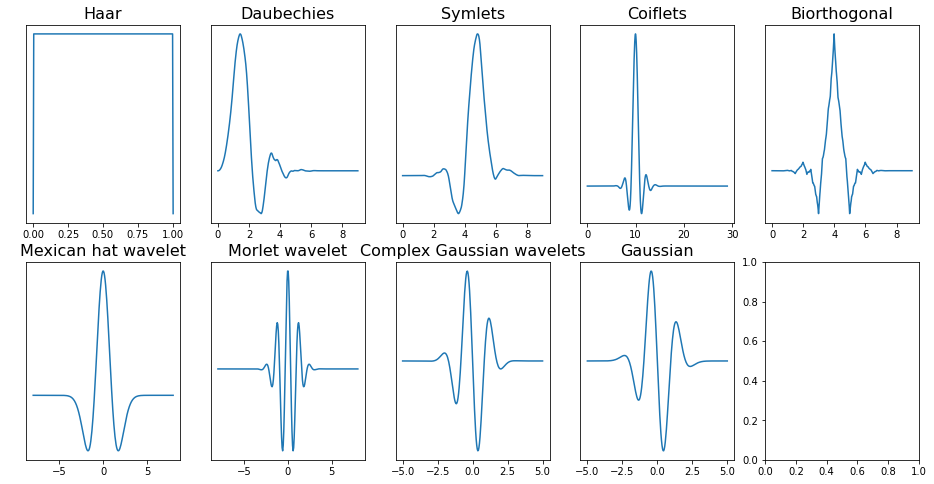

In [1]:
import matplotlib.pyplot as plt
import pywt
print(pywt.families(short=False))

import warnings
warnings.filterwarnings("ignore")

discrete_wavelets = ['haar','db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']

list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]
 
fig, axarr = plt.subplots(nrows=2, ncols=5, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel(" ", fontsize=16)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel(" ", fontsize=16)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])

<font size=5 color=#009999> <b>2. Filtering the ECG signal </b> </font> <br> <br>

In this part, we will handle ECG signals recorded in an ambulance with a Holter monitor. These signals are much less clean than clinical signals and hence require an excellent denoising to be interpreted. The final goal will be to automatically measure the heart rate (i.e. the mean duration of consecutive R-R intervals) from the ECG signal recorded in 2 patients.<br> 

The first ECG signal (<samp>ECGDATA_ecgA.csv</samp>, with associated sampling frequency 360 Hz) comes from a patient suffering from cardiac arrhythmia, and the second signal (<samp>ECGDATA_ecgN.csv</samp>, with associated sampling frequency 500 Hz) from a healthy patient. Look closely at these signals. Make note of the problems related to arrhythmia and to the recording environment (For instance, you can have a look at the time intervals $[4, 10]$ seconds for ecgA and $[80, 100]$ for ecgN). 

<br>

<font size=5 color=#009999> <i>2.1. Pre-filtering </i> </font> <br>

The first thing to do is to remove the power-line noise, at 50 or 60 Hz, from the signal. To this aim, we will use a Finite Impulse Response (FIR) filter. Visualize the signal before and after this operation and observe the influence of the filtering in the Fourier domain. <br>


<div class="alert alert-info">
<b>Remarks</b>  <br>
Since the design of an FIR filter is out of the scope of this course (covered in LELEC2900 - Signal processing), the implementation of such a filter is partially provided. This solution use the functions <samp>scipy.signal.firwin</samp> and <samp>scipy.signal.lfilter</samp>. Your job is to provide some quantitative specifications about the filter.
</div>

In [3]:
import numpy as np 
from scipy.signal import kaiserord, lfilter, firwin

import pandas as pd

from make_graphs import *

# -------------------------------------------------------------------------------------
# 1. Read the signals and compute their FFT
# -------------------------------------------------------------------------------------

##ECGA
ecgA = pd.read_csv("Data/ECGDATA_ecgA.csv")
freq_A = 360
ecgA=ecgA.to_numpy().flatten()
ecgA_freq = np.fft.fftshift(np.fft.fft(ecgA))
ecgA_freq_abs = np.fft.fftshift(np.fft.fftfreq(ecgA_freq.size,d=1/freq_A))

##ECGN
ecgN = pd.read_csv("Data/ECGDATA_ecgN.csv")
freq_N = 500
ecgN = ecgN.to_numpy().flatten()
ecgN_freq = np.fft.fftshift(np.fft.fft(ecgN))
ecgN_freq_abs = np.fft.fftshift(np.fft.fftfreq(ecgN_freq.size,d=1/freq_N))



# -------------------------------------------------------------------------------------
# 2. Pre-filtering (FIR filter)
# -------------------------------------------------------------------------------------

# Values in this dictionary have been assigen randomly. Modify them to obtain a filter that removes ferquencies 
# around 50 Hz
filterParam = {
    'width' : 0.05, # Width of transition region, normalized so that 1 corresponds to pi radians / sample. 
                    # That is, the frequency is expressed as a fraction of the Nyquist frequency.
    'ripple_db' : 50, # Upper bound for the deviation (in dB) of the magnitude of the filter’s frequency response 
                      # from that of the desired filter (not including frequencies in any transition intervals).
    'cutoff_hz' : [0.25] # Cutoff frequency of filter (expressed in the same units as fs) OR an array of cutoff 
                             # frequencies (that is, band edges). In the latter case, the frequencies in cutoff 
                             # should be positive and monotonically increasing between 0 and fs/2. 
                             # The values 0 and fs/2 must not be included in cutoff.
}

def FIRFilter(ecg, samp_freq, filterParam):
    """
    ecg:
    samp_freq:
    filterParam:
    """
    nyq_rate  = samp_freq / 2.0
    N, beta   = kaiserord(filterParam['ripple_db'], filterParam['width'])
    taps      = firwin(N, filterParam['cutoff_hz'], window=('kaiser', beta))

    return lfilter(taps, 1.0, ecg)
    

In [4]:
ecgA_FIR_T = FIRFilter(ecgA,freq_A,filterParam)
ecgA_FIR = np.fft.fftshift(np.fft.fft(ecgA_FIR_T))
ecgA_FIR_abs = np.fft.fftshift(np.fft.fftfreq(ecgA_FIR.size,d=2/freq_A))

In [5]:
ecgN_FIR_T = FIRFilter(ecgN,freq_N,filterParam)
ecgN_FIR = np.fft.fftshift(np.fft.fft(ecgN_FIR_T))
ecgN_FIR_abs = np.fft.fftshift(np.fft.fftfreq(ecgN_FIR.size,d=2/freq_N))

<font size=5 color=#009999> <i>2.2. Signal filtering using CWT </i> </font> <br>

We will now use the continuous wavelet transform (CWT) in order to improve our filtering. The CWT is capable of separating the useful information from noise such as the base line signal, muscle artifacts, breathing artifacts, etc. Keep in mind that the objective is to obtain a signal in which the R peaks are as easily as possible detected by a threshold. To obtain the continuous wavelet transform of a signal, we recommend to use the pywt.cwt function. According to the specifications, you will have to choose two crucial parameters:
   - **Wavelet** The Wavelet function to use (’mexh’, ’morl’, ’gaus1’, ’gaus2’,...).
   - **Scales** The wavelet scales to use. This can be an array or an integer.
   
Try different scales and determine which combination of scale and wavelet leads to a signal that will be the most suitable for automatic detection of the QRS complex. One example using a Mexican hat wavelet and a scale of 8 is depicted in the figure below. 

<table style="width:100%">
            <thead>
                <tr>
                    <th> ecgN </th>
                    <th> ecgA </th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td> <img src="imgs/Wavelet_ECGDATA_ecgN.png" width = "500"> </td>
                    <td> <img src="imgs/Wavelet_ECGDATA_ecgA.png" width = "500"> </td>
                </tr>
            </tbody>
    </table>      
<br>



In [13]:
import pywt

# -------------------------------------------------------------------------------------
# 3. Filtering with CWT
# -------------------------------------------------------------------------------------

### EcgA
ecgA_cwt,b = pywt.cwt(ecgA,[8],'mexh')
ecgA_cwt_frq = np.fft.fftshift(np.fft.fft(ecgA_cwt[0]))

### EcgN
ecgN_cwt,b = pywt.cwt(ecgN,[8],'mexh')
ecgN_cwt_frq = np.fft.fftshift(np.fft.fft(ecgN_cwt[0]))


#### EcgN

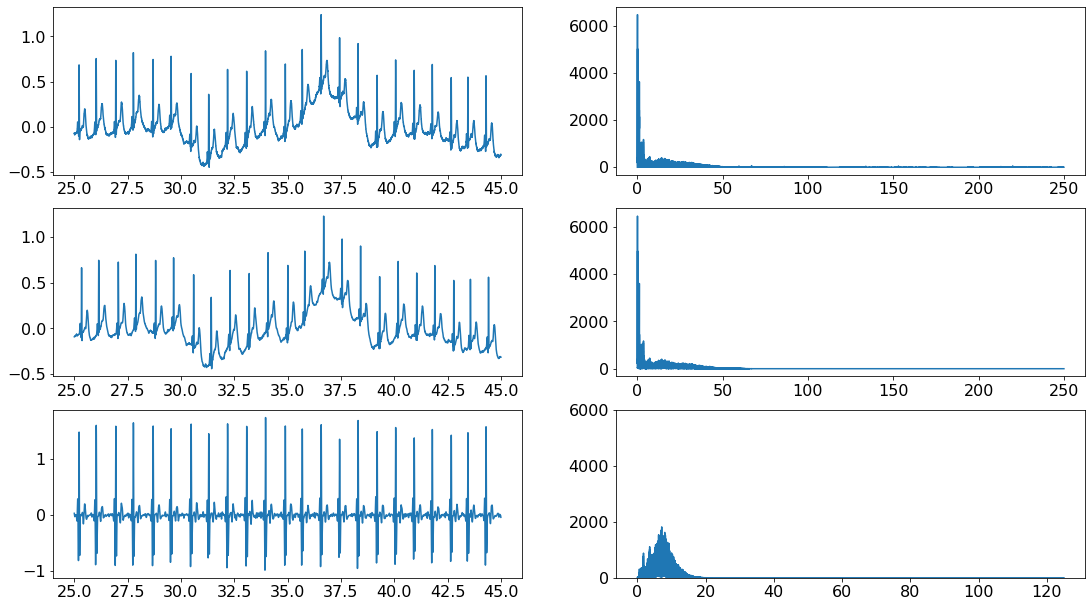

In [14]:
x_ecgN = np.arange(25,45,1/500)

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2)

fig.set_size_inches(18.5, 10.5)
ax1.plot(x_ecgN,ecgN[12500:12500+10000])
ax2.plot(ecgN_freq_abs[len(ecgN_freq_abs)//2:],(np.abs(ecgN_freq[len(ecgN_freq_abs)//2:])))
ax3.plot(x_ecgN,ecgN_FIR_T[12500:12500+10000])
ax4.plot(ecgN_freq_abs[len(ecgN_freq_abs)//2:],(np.abs(ecgN_FIR[len(ecgN_freq_abs)//2:])))
ax5.plot(x_ecgN,ecgN_cwt[0][12500:12500+10000])
ax6.plot(ecgN_FIR_abs[(len(ecgN_freq_abs)//2)+1:],(np.abs(ecgN_cwt_frq[(len(ecgN_freq_abs)//2)+1:])))
ax6.set_ylim(0,6000)
plt.show()

**EcgA**

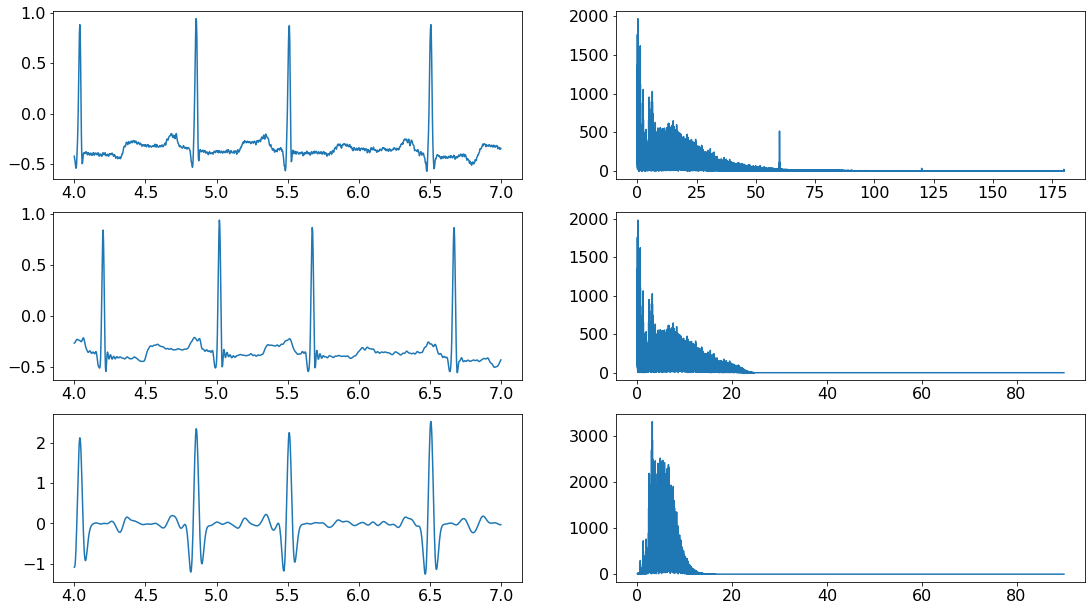

In [16]:
x_ecgA = np.arange(4,7,1/360)
#print(len(x_ecgA))
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2)
fig.set_size_inches(18.5, 10.5)
ax1.plot(x_ecgA,ecgA[1500:1500+1080])
ax2.plot(ecgA_freq_abs[(len(ecgA_freq_abs)//2)+1:],(np.abs(ecgA_freq[(len(ecgA_freq_abs)//2)+1:])))
ax3.plot(x_ecgA,ecgA_FIR_T[1500:1500+1080])
ax4.plot(ecgA_FIR_abs[(len(ecgA_freq_abs)//2)+1:],(np.abs(ecgA_FIR[(len(ecgA_freq_abs)//2)+1:])))
ax5.plot(x_ecgA,ecgA_cwt[0][1500:1500+1080])
ax6.plot(ecgA_FIR_abs[(len(ecgA_freq_abs)//2)+1:],(np.abs(ecgA_cwt_frq[(len(ecgA_freq_abs)//2)+1:])))
plt.show()

<font size=5 color=#009999> <i>2.3. Automatic measurement of the heart rate </i> </font> <br>

The heart rate measurement is crucial in most pharmaceutical studies and during the monitoring of patients in a hospital. An atypical heart rate variability is indeed an indicator of many diseases. Use the signal that you have filtered for the previous question in order to detect the R peaks. An algorithm that looks for the local maximum in a sliding window after a thresholding (as shown in figure below) is effective as long as the arrhythmia is not too strong and the wavelet transform has been well executed. Then compute the standard deviation of the R-R duration in milliseconds (pay attention to the fact that the 2 signals are sampled at different frequencies).

<table style="width:70%">
            <thead>
                <tr>
                    <th> ecgN </th>
                    <th> ecgA </th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td> <img src="imgs/Max_ECGDATA_ecgN.png" width = "300"> </td>
                    <td> <img src="imgs/Max_ECGDATA_ecgA.png" width = "300"> </td>
                </tr>
            </tbody>
    </table>      
<br>

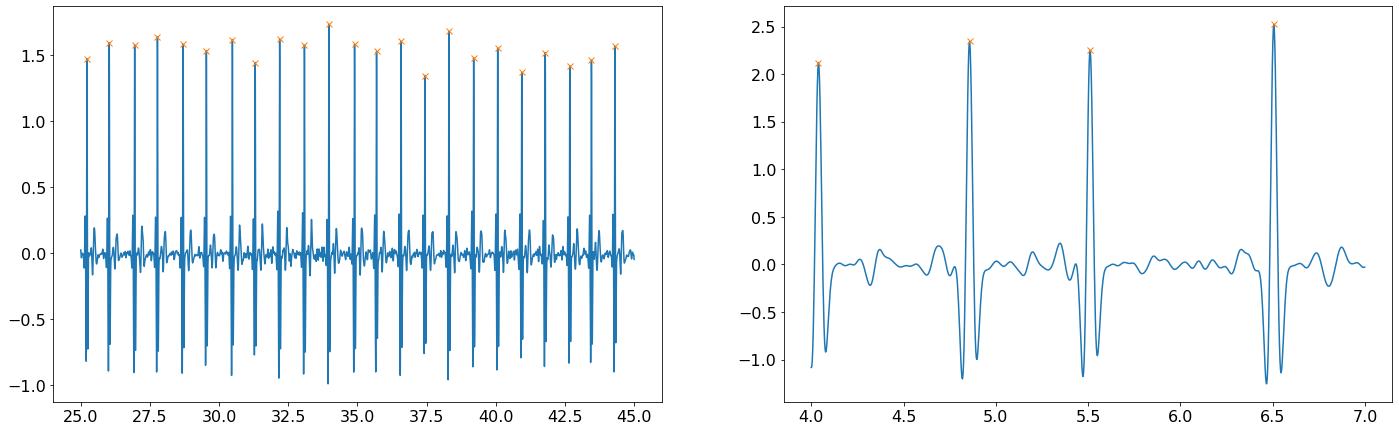

In [18]:
from scipy.signal import find_peaks

# -------------------------------------------------------------------------------------
# 3. Automatic measurement of the heart rate
# -------------------------------------------------------------------------------------
plt.figure(figsize=(24,16))
plt.subplot(221)
peaks,_ =find_peaks(ecgN_cwt[0][12500:12500+10000],distance = 350)
plt.plot(x_ecgN,ecgN_cwt[0][12500:12500+10000])
plt.plot(x_ecgN[peaks],ecgN_cwt[0][12500:12500+10000][peaks],"x")
plt.subplot(222)
plt.plot(x_ecgA,ecgA_cwt[0][1500:1500+1080])
peaks1,_ =find_peaks(ecgA_cwt[0][1500:1500+1080],distance = 200)
plt.plot(x_ecgA[peaks1],ecgA_cwt[0][1500:1500+1080][peaks1],"x")
plt.show()

<font size=5 color=#009999> <b>3. Use the DWT to denoise a signal  </b> </font> <br> <br>

<font size=5 color=#009999> <i>3.1. Develop your intuition about DWT </i> </font> <br>

In this exercice, we will use the Discrete Wavelet Transform, for which there exists a fast algorithm (the fast wavelet transform for 1-D signals of size $N$ is $\mathcal O(N)$!).
According to the [API reference](https://pywavelets.readthedocs.io/en/latest/ref/index.html), the functions we are interested in are:
-  <samp>pywt.dwt </samp> (resp.  <samp>pywt.idwt</samp>) for a *single-level* transform (resp. single-level inverse transform), and
-  <samp>pywt.wavedec </samp> (resp. <samp>pywt.waverec</samp>) to perform a *multi-level* decomposition (resp. multi-level reconstruction).

<font size=3 color=#009999> <b>Obtain the coefficients</b> </font> <br> 

In this first exercice, you are asked to complete the <samp>get_decomposition</samp> function which allows to get the n level coefficients of the DWT. The return value must be a list of the form $[cA_n, cD_n, cD_{n-1}, …, cD_2, cD_1]$, where fhe first element ($cA_n$) is the approximation coefficients array and the following elements ($cD_n - cD_1$) are the details coefficients arrays.

<font size=3 color=#009999> <b>DWT of "toy example" signals</b> </font> <br> 

Generate a time plot for all 4 signals provided in the following cell. Now, without computing the results, try to guess what will be the discrete wavelet decomposition of these signals into approximation and detailed coefficients. 
The, compare your result thanks to the <samp>print_decomposition</samp> function. Vary the level and the wavelet family and comment their impact on the decomposition. 

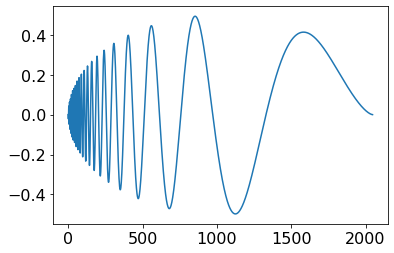

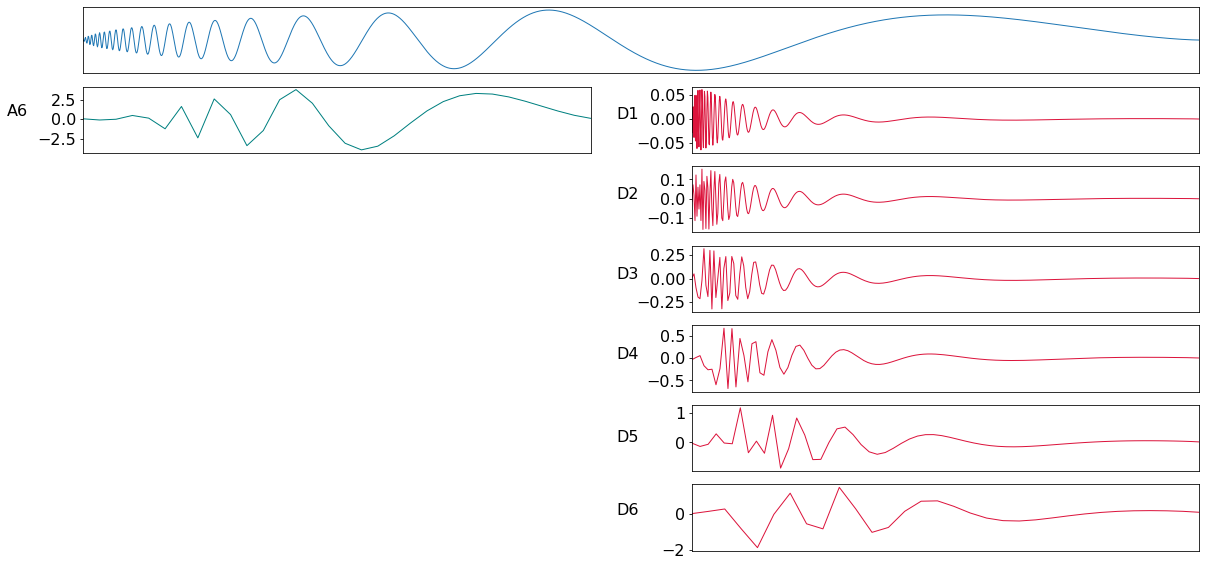

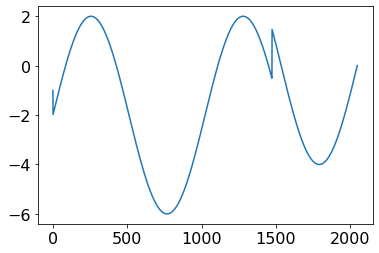

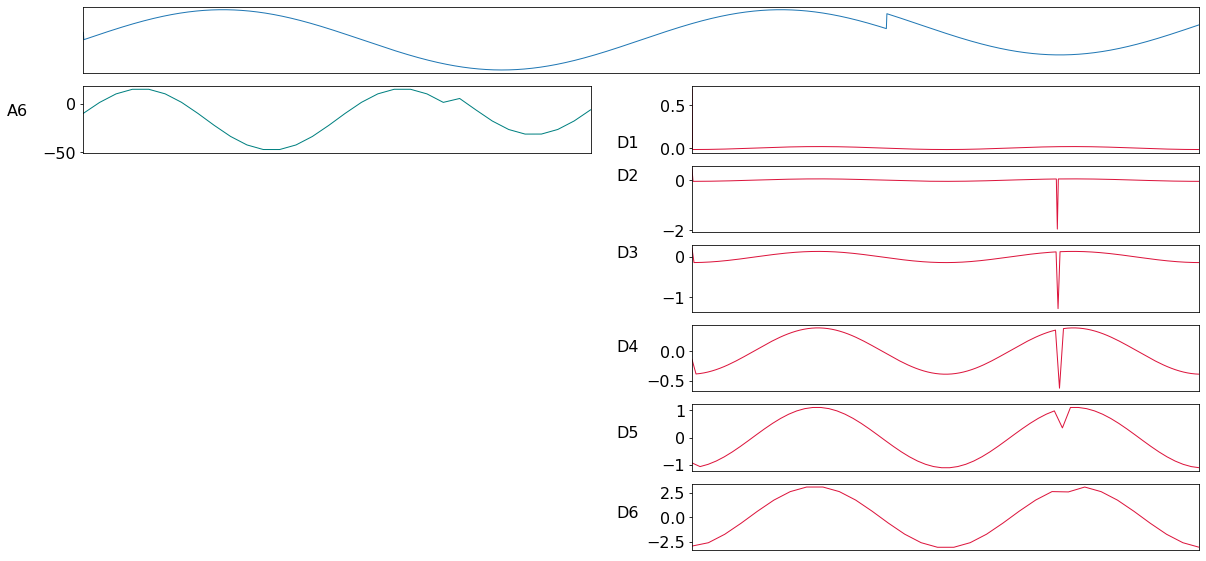

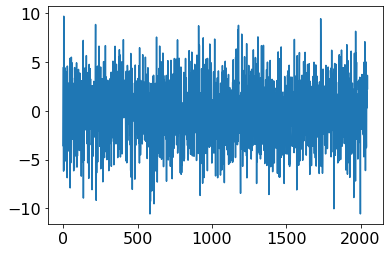

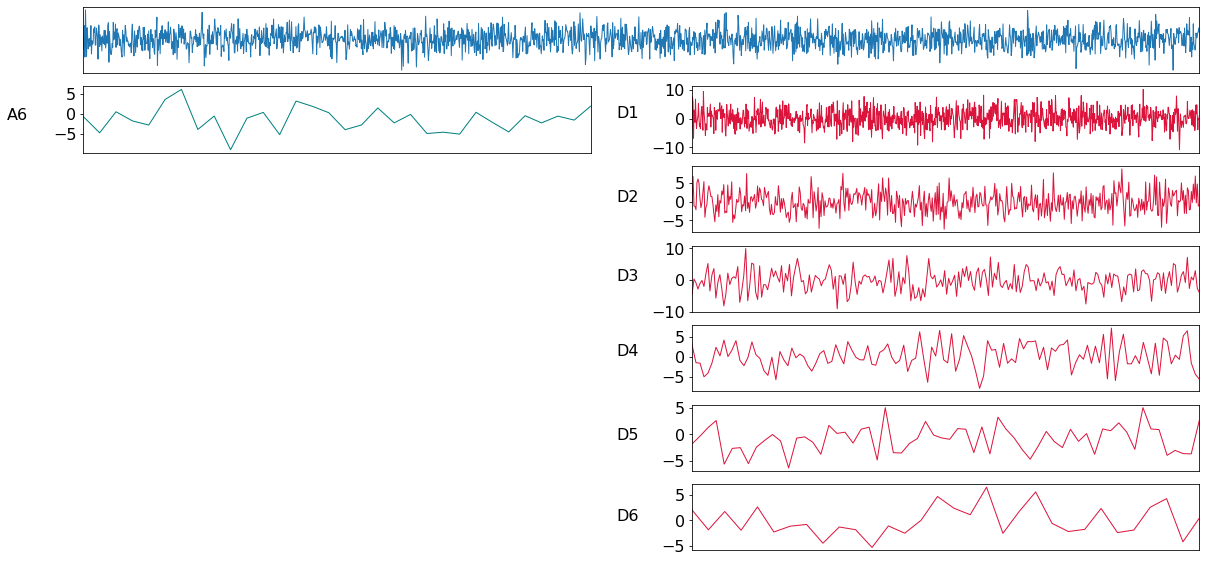

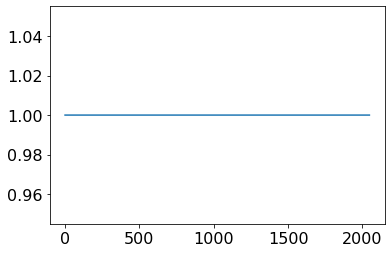

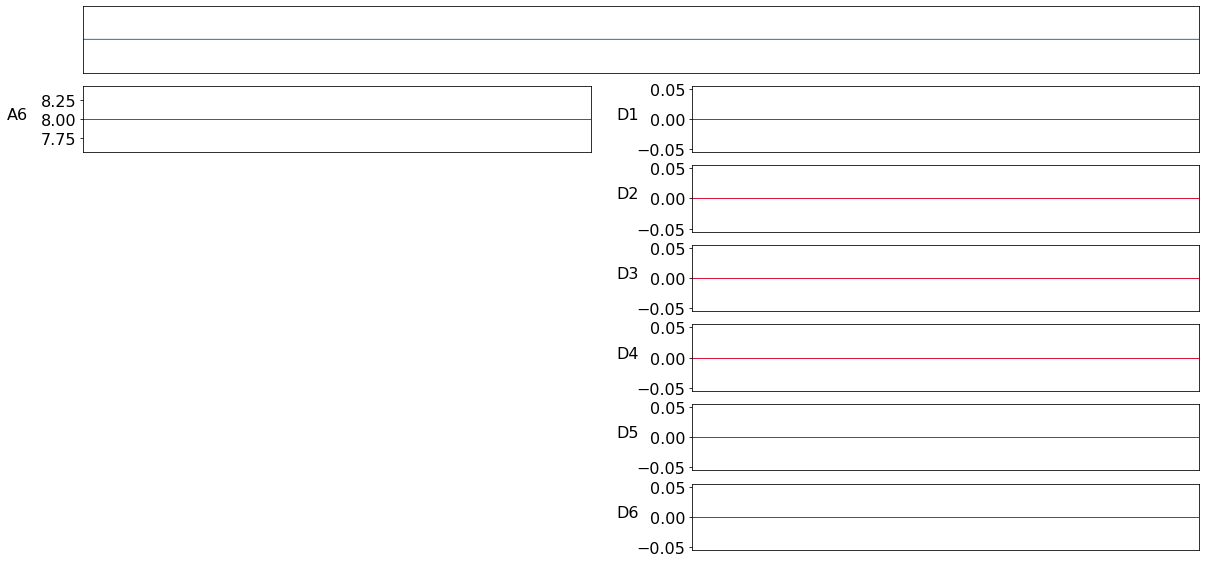

In [19]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import matplotlib.pyplot as plt
import pywt

"""
This functions applies a (default=6) level DWT on the signal array for a given wavelet  (default=haar) basis 
function. The returned values are the coefficients in the following order : [cA_n, cD_n, cD_n-1, …, cD_2, cD_1] 
"""
def get_decomposition(signal, show_graph=True, wavelet_type = 'haar', level=6):     
    
    coeffs = pywt.wavedec(signal,wavelet_type,level=level)
    if show_graph : 
        print_decomposition(signal, coeffs)
    return coeffs
 
"""
Plot the wavelet decomposition of a singal based on the (previously) computed approximation and detail coefficients.
"""
def print_decomposition(signal, coeffs):

    approx_coeffs, detail_coeffs = coeffs[0], coeffs[1:]
    fig = plt.figure(figsize=(20,10))
    ax_main = fig.add_subplot(len(detail_coeffs) + 1, 1, 1)
    ax_main.plot(signal, linewidth=1)
    ax_main.set_xlim(0, len(signal) - 1)
    ax_main.get_xaxis().set_visible(False)
    ax_main.get_yaxis().set_visible(False)

    ax = fig.add_subplot(len(detail_coeffs) + 1, 2, 3 )
    ax.plot(approx_coeffs, 'teal', linewidth=1)
    ax.set_xlim(0, len(approx_coeffs) - 1)
    ax.patch.set_alpha(0)
    #ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    plt.text(-(len(approx_coeffs) - 1)*0.15, np.mean(approx_coeffs), "A%d" % len(detail_coeffs))

    for i, y in enumerate(detail_coeffs[::-1]):
        ax = fig.add_subplot(len(detail_coeffs) + 1, 2, 4 + i * 2)
        ax.plot(y, 'crimson', linewidth=1)
        ax.set_xlim(0, len(y) - 1)
        #ax.get_yaxis().set_visible(False)
        if i != len(approx_coeffs)-1:
            ax.get_xaxis().set_visible(False)
        plt.text(-(len(y) - 1)*0.15, np.mean(y), "D%d" % (i + 1))

    # Display graph on screen
    plt.show()
    plt.close()
    
x = np.linspace(0, 1, 2048)
all_signals = {}

# Signal 1
epsilon = 0.05
all_signals['sig1'] = np.sqrt(x*(1-x))*np.sin(2*np.pi*(1+epsilon)/(x+epsilon))
# Signal 2
all_signals['sig2'] = 4*np.sin(4*np.pi*x) - np.sign(x/0.7) - np.sign(0.72-x)
# Signal 3 
all_signals['sig3'] = np.random.normal(0, 3, 2048)
# Signal 4
all_signals['sig4'] = np.ones(2048)

flatten = lambda l: [item for sublist in l for item in sublist]

for key in all_signals : 
    plt.plot(all_signals[key])
    coeffs = get_decomposition(all_signals[key])

<font size=5 color=#009999> <i>3.2. Noise filtering in the neurogram </i> </font> <br>

We will now use the discrete wavelet transform to remove artifacts in invasive recordings of the vagus nerve in a rat. As the vagus nerve is close to the heart and in addition cardiac activities pass through it, the neurogram is contaminated with heart interference, preventing the analysis of the amplitude of the nerve activity. There are also artifacts related to the respiration of the animal and to the blood pressure.<br> 

The <samp>NERVE_nrv.csv</samp> file contains an invasive recording of 5 seconds of activity of the vagus nerve recorded in a rat. <samp>NERVE_ekg.csv</samp> contains the ECG signal recorded in parallel. The data is sampled at 16384 Hz. The nervous activity corresponds to high frequencies while cardiac, respiratory and plethysmographic artifacts have lower frequencies.<br> 

The goal here will hence be to filter these artifacts in the neurogram using the discrete wavelet transform. The idea is to perform the decomposition until the "approximation coefficients" only contain the artifacts. Then, all you have to do is to add up the "detail coefficients" until this stage in order to obtain the nerve activity separated from the rest. The result is illustrated below.

<img src="imgs/nerve_activity.png" width = "600">

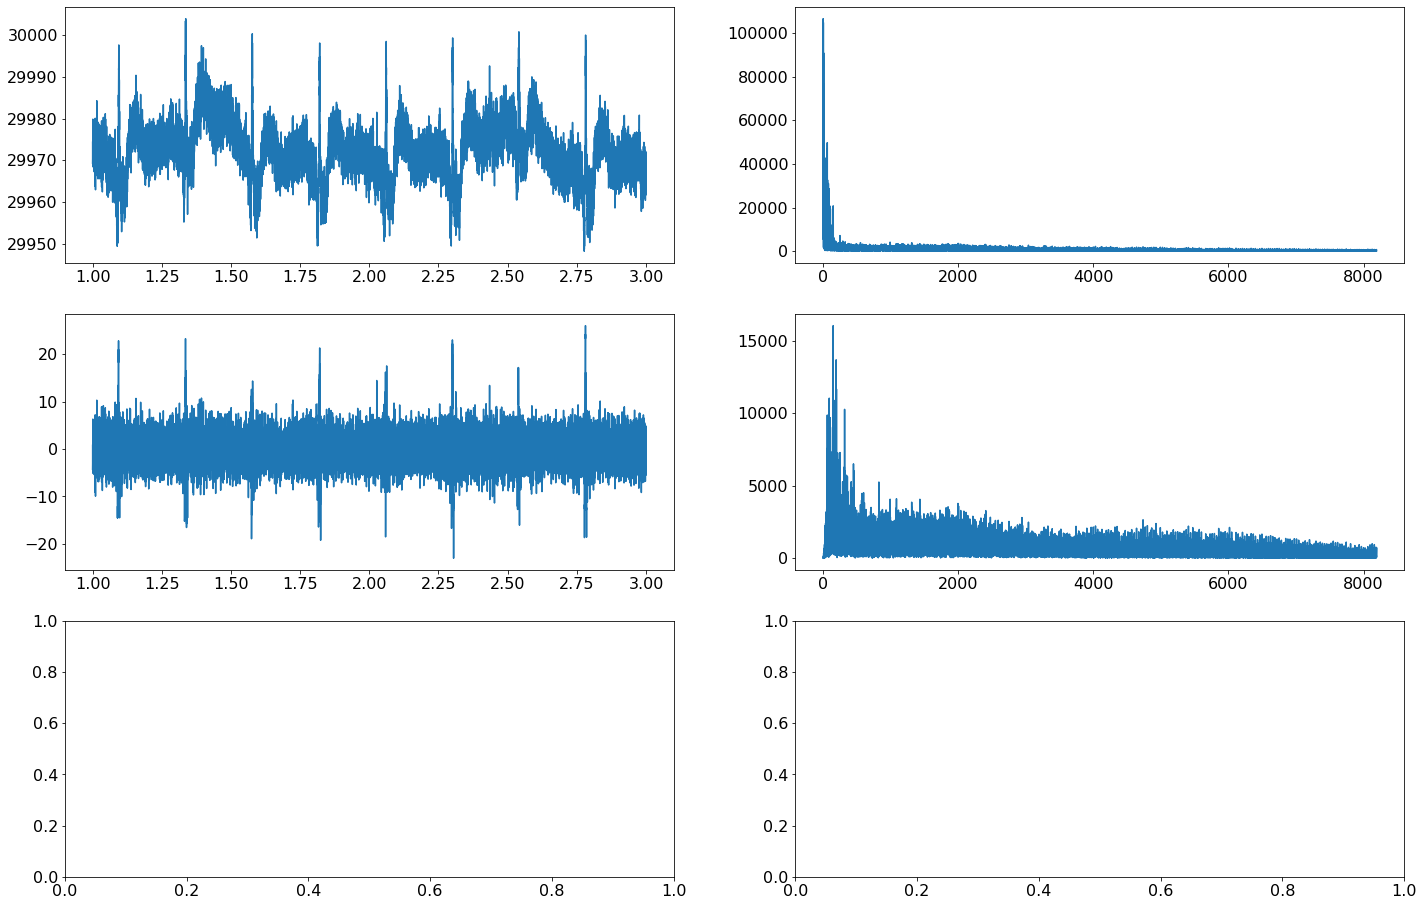

In [49]:
# -------------------------------------------------------------------------------------
# 1. Read the signals and compute FFT
# -------------------------------------------------------------------------------------
ecgNerve = pd.read_csv("Data/NERVE_nrv.csv")
ecgNerve=ecgNerve.to_numpy().flatten()
x_Nerve = np.arange(1,3,1/16384)
ecgNerve_freq = np.fft.fftshift(np.fft.fft(ecgNerve))
ecgNerve_freq_abs = np.fft.fftshift(np.fft.fftfreq(ecgNerve_freq.size,d=1/16384))


# -------------------------------------------------------------------------------------
# 2. Compute the coefficient of DWT
# -------------------------------------------------------------------------------------
coeffs = get_decomposition(ecgNerve,show_graph=False)
coeffs[0]=np.zeros(len(coeffs[0]))
#coeffs[1]=np.zeros(len(coeffs[1]))
#coeffs[2]=np.zeros(len(coeffs[2]))
#coeffs[3]=np.zeros(len(coeffs[3]))
#coeffs[6]=np.zeros(len(coeffs[6]))


ecgNerve_wave = pywt.waverec(coeffs,'haar')
ecgNerve_wave_freq = np.fft.fftshift(np.fft.fft(ecgNerve_wave))
ecgNerve_wave_freq_abs = np.fft.fftshift(np.fft.fftfreq(ecgNerve_wave_freq.size,d=1/16384))
# -------------------------------------------------------------------------------------
# 3. Separate nerve activity from artifacts
# -------------------------------------------------------------------------------------


plt.figure(figsize=(24,16))
plt.subplot(321)
plt.plot(x_Nerve,ecgNerve[16384:16384+len(x_Nerve)])
plt.subplot(322)
plt.plot(ecgNerve_freq_abs[(len(ecgNerve_freq_abs)//2)+1:],(np.abs(ecgNerve_freq[(len(ecgNerve_freq)//2)+1:])))
plt.subplot(323)
plt.plot(x_Nerve,ecgNerve_wave[16384:16384+len(x_Nerve)])
plt.subplot(324)
plt.plot(ecgNerve_wave_freq_abs[(len(ecgNerve_wave_freq_abs)//2):],(np.abs(ecgNerve_wave_freq[(len(ecgNerve_wave_freq)//2):])))
plt.subplot(325)
plt.subplot(326)
plt.show()